In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from resnet18k import make_normalized_resnet18k, make_resnet18k, Normalizer

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda')
# Load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load the model
model = make_normalized_resnet18k().to(device)
model.load_state_dict(torch.load('resnet18_cifar10_nodp.pt'))
model.eval()

# Get the accuracy of the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the model on the {total} test images: {100 * correct / total} %')

Files already downloaded and verified
Accuracy of the model on the 10000 test images: 88.43 %


# Partial PGD attack on Resnet18 + CIFAR-10

In [12]:

from hx_partialpgd import make_ref_images, pgd_attack, partial_pgd_attack, compute_linf,make_multiple_ref_images


In [7]:
# Utility function to show an image
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Utility function to show multiple images with titles in subplots
def imshow_multi(images, titles, ncols=5):
    nrows = len(images) // ncols + 1
    fig = plt.figure(figsize = (15, 15*(nrows/ncols)))
    for i in range(len(images)):
        ax = fig.add_subplot(len(images) // ncols + 1, ncols, i + 1)
        npimg = images[i].numpy()
        ax.imshow(np.transpose(npimg,(1,2,0)))
        ax.set_title(titles[i])
    plt.show()


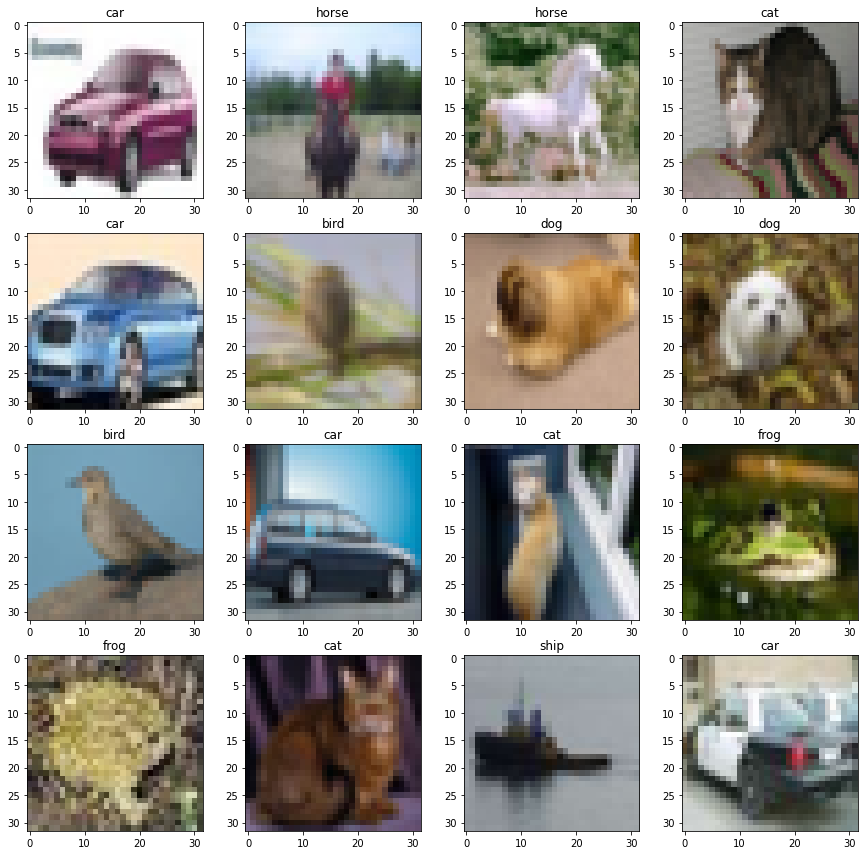

In [8]:
# Get 16 random images from the test set and show them
shufloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)
images, labels = next(iter(shufloader))
imshow_multi(images, [cifar10_classes[i] for i in labels], ncols=4)

In [9]:
orig_outputs = model(images.to(device))
_, orig_preds = torch.max(orig_outputs, 1)
orig_preds = orig_preds.cpu()

Iter 0 cost 2.717914342880249
Iter 1 cost 10.512776374816895
Iter 2 cost 14.534435272216797
Iter 3 cost 15.513927459716797
Iter 4 cost 15.741522789001465
Iter 5 cost 15.825868606567383
Iter 6 cost 15.808679580688477
Iter 7 cost 15.791952133178711
Iter 8 cost 15.779821395874023
Iter 9 cost 15.796364784240723
Iter 10 cost 15.811901092529297
Iter 11 cost 15.781744956970215
Iter 12 cost 15.787795066833496
Iter 13 cost 15.807503700256348
Iter 14 cost 15.79751205444336
Iter 15 cost 15.788990020751953
Iter 16 cost 15.781532287597656
Iter 17 cost 15.793133735656738
Iter 18 cost 15.762615203857422
Iter 19 cost 15.782113075256348
Iter 20 cost 15.794546127319336
Iter 21 cost 15.830191612243652
Iter 22 cost 15.804645538330078
Iter 23 cost 15.847325325012207
Iter 24 cost 15.804222106933594
Iter 25 cost 15.825183868408203
Iter 26 cost 15.82008171081543
Iter 27 cost 15.824325561523438
Iter 28 cost 15.818804740905762
Iter 29 cost 15.851690292358398
Iter 30 cost 15.821120262145996
Iter 31 cost 15.80313

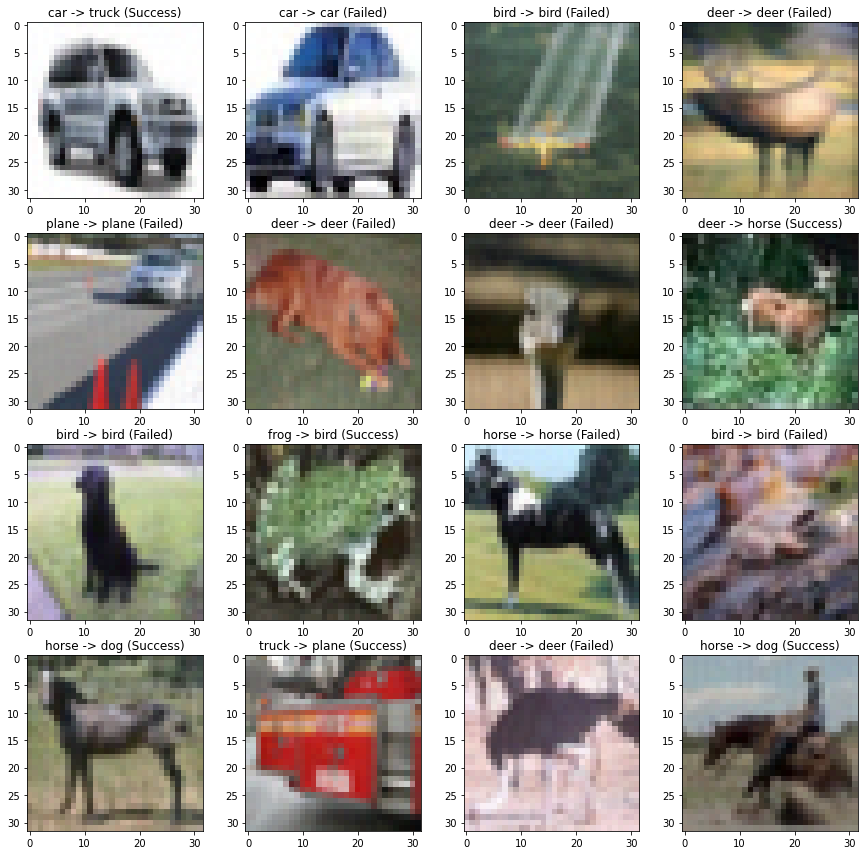

In [8]:
# Run PGD attack
adv_images = pgd_attack(model, images, labels, eps=2/255)

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)


In [9]:
# Compute the L_inf norm of the perturbation
print(f"L_inf norm of perturbation: {compute_linf(images, adv_images)}")

L_inf norm of perturbation: 0.007843166589736938


In [10]:
pip install foolbox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Success rate: 0.6875


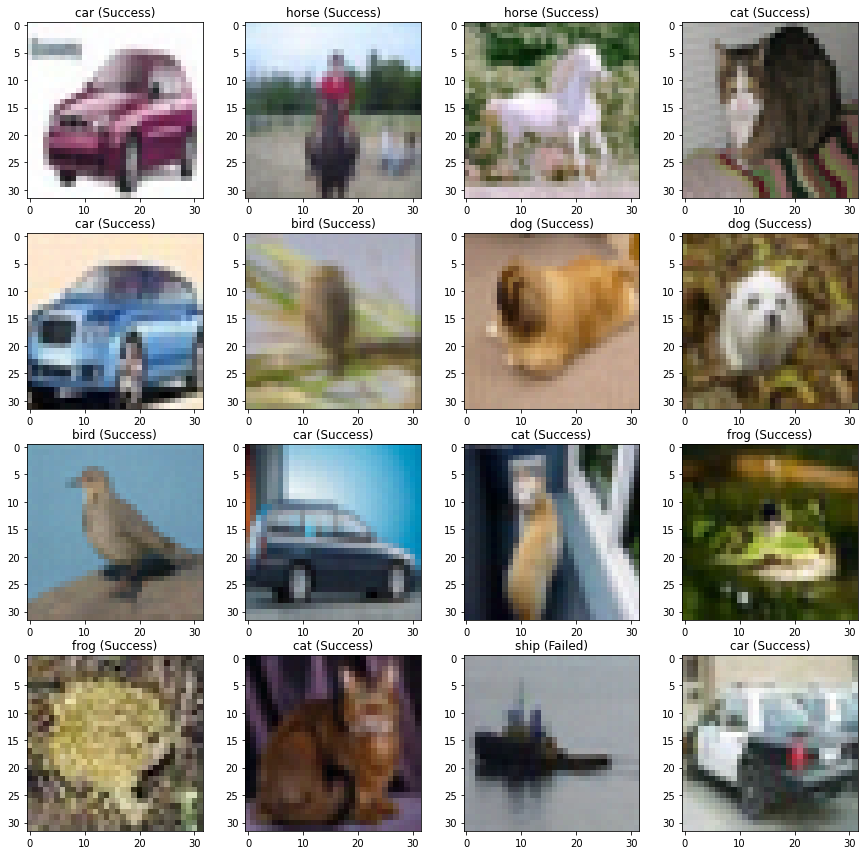

In [10]:
import foolbox as fb
fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfPGD()
images = images.to(device)
labels = labels.to(device)
_, advs, success = attack(fmodel, images, labels, epsilons=2/255)
print(f"Success rate: {success.sum().item()/len(labels)}")
imshow_multi(advs.cpu(), [cifar10_classes[i] + (' (Success)' if success[i] else ' (Failed)') for i in labels], ncols=4)

Batch 0 of 100, 0 ref images found
Success rate: 0.125


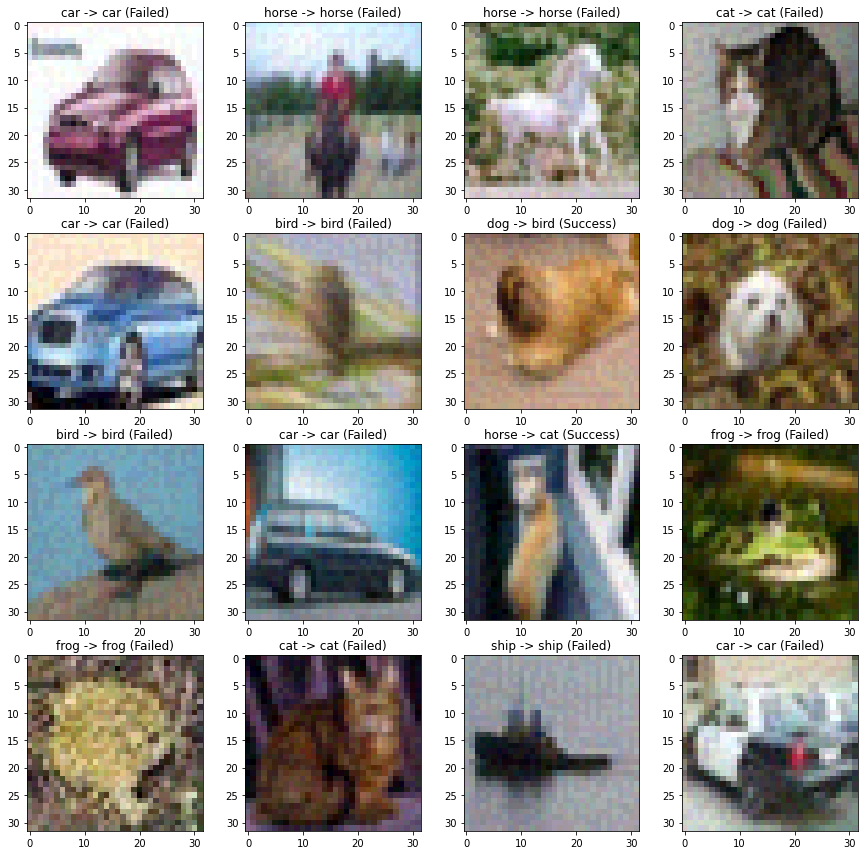

In [13]:
# Try the partial attack
ref_images = make_ref_images(model, testloader)
adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer2', eps=8/255, alpha=0.05, iters=40, init_random='normal')

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# # Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)

In [ ]:
# Try the partial attack
ref_images = make_ref_images(model, testloader)
adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer1', eps=8/255, alpha=0.05, iters=40, init_random='normal')

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# # Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)

Batch 0 of 100, 0 ref images found
Success rate: 0.3125


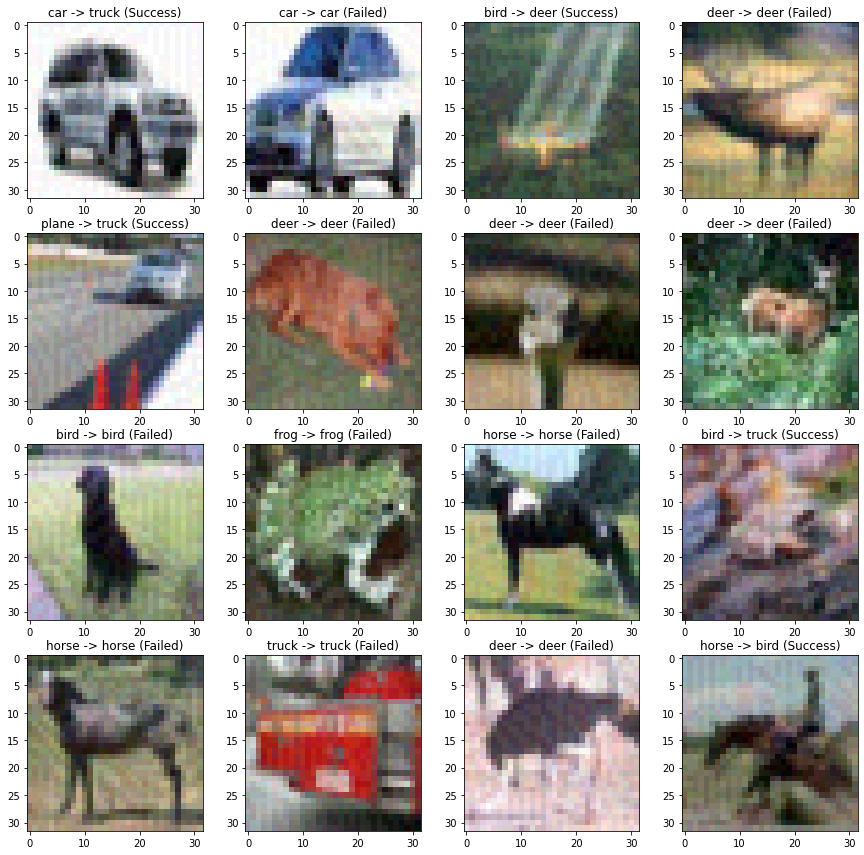

In [25]:
# Try the partial attack
ref_images = make_ref_images(model, testloader)
adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer3', eps=8/255, alpha=0.05, iters=40, init_random='normal')

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# # Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)

In [12]:
from partialpgd import make_ref_images, pgd_attack, partial_pgd_attack, compute_linf,make_multiple_ref_images

In [13]:
# Try the partial attack
images_per_class=5
ref_images = make_multiple_ref_images(model, testloader,images_per_class=images_per_class)
#ref_images = make_ref_images(model, testloader)
adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer2', eps=8/255, alpha=0.05, iters=40,images_per_class=images_per_class, init_random='normal')

# Get the new predictions
outputs = model(adv_images.to(device))
_, preds = torch.max(outputs, 1)

# Move the images back to the CPU
images = images.cpu()
labels = labels.cpu()
adv_images = adv_images.cpu()
preds = preds.cpu()

success = (preds != orig_preds)
print(f"Success rate: {success.sum().item()/len(orig_preds)}")

# # Show the original and adversarial images
imshow_multi(adv_images.cpu(),
             [f'{cifar10_classes[i]} -> {cifar10_classes[j]} ({"Success" if success[idx] else "Failed"})' for idx,(i,j) in enumerate(zip(orig_preds,preds))],
             ncols=4)

{0: [], 1: [], 2: [], 3: [], 4: []}


KeyError: 8

In [13]:
import seaborn as sns

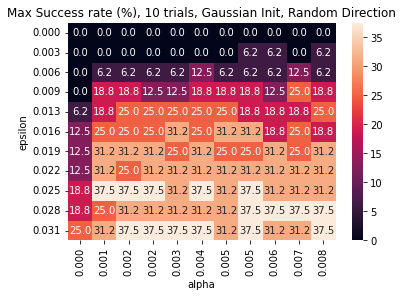

In [14]:
# Do a sweep over epsilons and alphas
epsilons = np.linspace(0, 8/255, 11)
#alphas = np.linspace(0, 8/255, 11)
alphas = epsilons/4
trials = 10
successes = np.zeros((trials, len(epsilons), len(alphas)))
for t in range(trials):
    for i, eps in enumerate(epsilons):
        for j, alpha in enumerate(alphas):
            adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer2', eps=eps, alpha=alpha, iters=40, init_random='normal', attack_type='random')
            outputs = model(adv_images.to(device))
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            successes[t,i,j] = (preds != orig_preds).sum().item()/len(orig_preds)

# Plot the results
sns.heatmap(successes.max(axis=0)*100, xticklabels=[f'{a:.3f}' for a in alphas], yticklabels=[f'{e:.3f}' for e in epsilons], annot=True, fmt='.1f')
plt.xlabel('alpha')
plt.ylabel('epsilon')
plt.title('Max Success rate (%), 10 trials, Gaussian Init, Random Direction')
plt.show()

In [ ]:
# Do a sweep over epsilons and alphas
epsilons = np.linspace(0, 8/255, 11)
alphas = np.linspace(0, 8/255, 11)
trials = 10
successes = np.zeros((trials, len(epsilons), len(alphas)))
for t in range(trials):
    for i, eps in enumerate(epsilons):
        for j, alpha in enumerate(alphas):
            adv_images = partial_pgd_attack(model, images, labels, ref_images, layer='model.layer2', eps=eps, alpha=alpha, iters=40, init_random='uniform')
            outputs = model(adv_images.to(device))
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            successes[t,i,j] = (preds != orig_preds).sum().item()/len(orig_preds)

# Plot the results
sns.heatmap(successes.max(axis=0)*100, xticklabels=[f'{a:.3f}' for a in alphas], yticklabels=[f'{e:.3f}' for e in epsilons], annot=True, fmt='.1f')
plt.xlabel('alpha')
plt.ylabel('epsilon')
plt.title('Max Success rate (%), 10 trials, Uniform Init')
plt.show()

ValueError: node: 'Sequential(
  (0): PreActBlock(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
  )
  (1): PreActBlock(
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)' is not present in model. Hint: use `get_graph_node_names` to make sure the `return_nodes` you specified are present. It may even be that you need to specify `train_return_nodes` and `eval_return_nodes` separately.